In [1]:
import torch as t
import numpy as np
from torch import nn
import createdFuncs as past
import fancy_einsum as einsum
import einops
import pandas as pd


# Training Shakespeare Himself

## Copy transformer code



Well, not copy entirely - I'm gonna put down optimizations so it can use the GPU

In [2]:
def multihead_masked_attention(Q: t.Tensor, K: t.Tensor, V: t.Tensor, num_heads: int):
    '''
    Implements multihead masked attention on the matrices Q, K and V.

    Q: shape (batch, seq_len, nheads*headsize)
    K: shape (batch, seq_len, nheads*headsize)
    V: shape (batch, seq_len, nheads*headsize)
    '''
    
    Q = einops.rearrange(Q, 'b s (n h) -> b n s h', n = num_heads)
    K = einops.rearrange(K, 'b s (n h) -> b n s h', n = num_heads)
    V = einops.rearrange(V, 'b s (n h) -> b n s h', n = num_heads)


    scores = einsum.einsum('b n k h, b n s h -> b n s k', K, Q)
    assert scores.shape == t.Size([Q.shape[0], num_heads,Q.shape[2], K.shape[2]])

    scores = scores / np.sqrt(Q.shape[-1])
    attention = scores + t.triu(t.ones_like(scores) * float("-inf"), diagonal=1) # THIS IS STOLEN FROM JAY - testing it out
    softed = t.softmax(attention,dim=-1)
    result =  einsum.einsum('batch numheads seqQ seqK, batch numheads seqK headsize -> batch numheads seqQ headsize',softed, V)
    return einops.rearrange(result, 'batch numheads seqQ headsize -> batch seqQ (numheads headsize)')

In [3]:
class MultiheadMaskedAttention(nn.Module):
    W_QKV: nn.Linear
    W_O: nn.Linear

    def __init__(self, hidden_size: int, num_heads: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        self.WQKV = t.nn.Linear(self.hidden_size, 3 * hidden_size) # TODO: why do we use a linear layer here? aren't they matricies?
        self.W0 = t.nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, seq, hidden_size)

        Return: shape (batch, seq, hidden_size)
        '''
        #print("YO?")
        x = x.float() # seems like it needs to be a float!
        QKV = self.WQKV(x)
        Q = QKV[:,:,:self.hidden_size]
        K = QKV[:,:,self.hidden_size:self.hidden_size * 2]
        V = QKV[:,:,self.hidden_size * 2:]
        assert Q.shape == K.shape == V.shape == x.shape
        return self.W0(multihead_masked_attention(Q,K,V,self.num_heads))

In [4]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TransformerConfig:
    '''Constants used throughout your decoder-only transformer model.'''

    num_layers: int
    num_heads: int
    vocab_size: int
    hidden_size: int
    max_seq_len: int
    dropout: float = 0.1
    layer_norm_epsilon: float = 1e-05

In [5]:
# from yesterday
class PositionalEncoding(nn.Module):

    def __init__(self, embedding_dim: int, max_seq_len: int = 5000):
        super().__init__()
        self.dim = embedding_dim
        self.length = max_seq_len

        # mostly copied. i understand this, just need to work on 
        # making more tensors and getting more exposure to methods of making tensors
        def P (delta):
            n = 10000 # hardcoded
            d = embedding_dim
            l = max_seq_len
            sin_array = np.sin(delta / n ** (2 * np.arange(d//2) / d))
            cos_array = np.cos(delta / n ** (2 * np.arange(d//2) / d))

            array = np.zeros(d)
            array[::2] = sin_array
            array[1::2] = cos_array

            return array

        tokenArray = []
        for i in range(max_seq_len):
            tokenArray.append(P(i)) # changed from previous design
        
        self.multMax = t.tensor(np.array(tokenArray), dtype=float)
        

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, seq_len, embedding_dim)
        '''
        return x + self.multMax[:x.shape[1]]


In [6]:
class MLP(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.layers = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size * 4),
            nn.GELU(),
            nn.Linear(self.hidden_size * 4, self.hidden_size),
            nn.Dropout(config.dropout)
        )
    def forward(self, x: t.Tensor):
        x = x.float() # seems like it needs to be a float!
        return self.layers(x).float() # ima do the same thing again!


In [7]:
class DecoderBlock(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.attentionBlock = nn.Sequential(
            MultiheadMaskedAttention(config.hidden_size,  config.num_heads),
            nn.LayerNorm(config.hidden_size)
        )
        self.MLP = nn.Sequential(
            MLP(config),
            nn.LayerNorm(config.hidden_size)
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        partOne = x + self.attentionBlock(x)
        return (partOne + self.MLP(partOne)).float() # seems like it needs to be a float!
        

In [8]:
class DecoderOnlyTransformer(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.tokenize = nn.Embedding(config.vocab_size, config.hidden_size)
        self.positionize = PositionalEncoding(config.hidden_size,config.max_seq_len)
        self.restModel = nn.Sequential(
            nn.Dropout(config.dropout),
            *[DecoderBlock(config) for i in range(config.num_layers)],
            nn.LayerNorm(config.hidden_size),
        )
        self.unembed = self.tokenize.weight.T
        
    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.tokenize(x)
        x = self.positionize(x)
        toUnembed = self.restModel(x)
        return toUnembed@self.unembed

In [ ]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

## Data Prep

Make the dataset to parse through all of the words

In [176]:
import re
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

class CustomTextDataset(Dataset):
    def __init__(self, words, seq_len, fractionOfWords):
        self.fractionOfWords = fractionOfWords
        self.words = words
        self.setOfWords = set(words)
        self.seq_len = seq_len
        self.max_len = len(self.words) - (self.seq_len + 1)
        self.vocab_size = len(self.setOfWords)
        self.word_to_token = {word: idx for (idx, word) in enumerate(sorted(self.setOfWords))}
        self.token_to_word = {idx: word for (idx, word) in enumerate(sorted(self.setOfWords))}
        self.allTokens = t.tensor([self.word_to_token[word] for word in self.words])
        
        if (self.fractionOfWords > 0.9):
            print("Probably don't do this. Errors may about")

    def __len__(self):
        return int(self.max_len * self.fractionOfWords)

    def __getitem__(self, idx):
        tokens = self.allTokens[idx:idx + self.seq_len + 1]
        input = tokens[:-1]
        target = tokens[1:]
        return input, target 

    def getDataSize(self):
        return self.vocab_size

    def convertToTokens(self, phrase: list):
        return t.tensor([self.word_to_token[word] for word in phrase])

    def convertToText(self, tokens: t.tensor):
        temp = []
        for i, value in enumerate(tokens):
            #print(value.item())
            temp.append(self.token_to_word[value.item()])
        return temp

In [177]:
file = open("shakespeare.txt")
text = file.read()
words = re.split(r"\b", text)

fractionOfWords = 0.004 # what percent of the corpus to train on 


lengthOfSeq = 20

shak = CustomTextDataset(words, 10, fractionOfWords)

## Running this data through a transformer

In [130]:
trainloader = DataLoader(shak, batch_size=32,shuffle=True)


thisConfig = TransformerConfig(
    num_layers = 2,
    num_heads = 4,
    vocab_size = trainloader.dataset.getDataSize(),
    hidden_size = 40, # recall that this = num_heads * headsize
    max_seq_len = lengthOfSeq,
    dropout = 0.1,
    layer_norm_epsilon=0.00001
)

myTransformer = DecoderOnlyTransformer(thisConfig)
optimizer = t.optim.Adam(myTransformer.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()


In [179]:
NUM_EPOCHS = 1

#losses = []
myTransformer.train()
for epoch in range(1, NUM_EPOCHS + 1):
    for inputs, targets in trainloader:
        outputs = myTransformer(inputs)
        targets = t.nn.functional.one_hot(targets, num_classes=trainloader.dataset.getDataSize()).float()
        
        outputs = einops.rearrange(outputs, 'batch seq vocab -> (batch seq) vocab')
        targets = einops.rearrange(targets, 'batch seq vocab -> (batch seq) vocab')

        loss = criterion(outputs,targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


<AxesSubplot: >

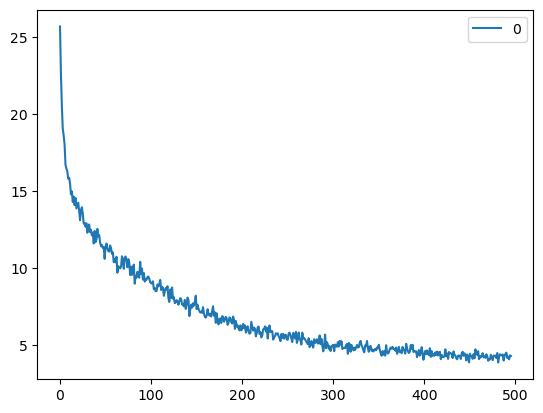

In [180]:
df = pd.DataFrame(losses)
df.plot()

In [185]:
# quick test:

myTransformer.eval()

testPhrase = ["where", " ", "find", " ", "he", " ", "go"]
input = shak.convertToTokens(list(testPhrase))
input = input[None, :]
tokens = myTransformer(input).argmax(dim=-1)[0]
print(tokens)
shak.convertToText(tokens)


tensor([  111, 21548,   111, 21548,   111, 21548,   111])


[' ', 'in', ' ', 'in', ' ', 'in', ' ']